# Quantification des incertitudes - Solution


In [1]:
import openturns as ot
import openturns.viewer as otv
import os

In [2]:
ot.__version__

'1.26'

## Génération de l'échantillon

In [3]:
# Définition des paramètres exacts de la loi Beta
alpha_exact = 0.9
beta_exact = 2.6
a_exact = 65.0  # GPa
b_exact = 75.0  # GPa

# Affectation dans un vecteur de dimension 4 (Point)
# L'ordre standard dans OpenTURNS pour la loi Beta est [alpha, beta, a, b]
exact_parameters = ot.Point([alpha_exact, beta_exact, a_exact, b_exact])

# Affichage du vecteur
print(f"Vecteur des paramètres exacts : {exact_parameters}")

Vecteur des paramètres exacts : [0.9,2.6,65,75]


In [4]:
generate_sample = not os.path.isfile("sample_E.csv")
if generate_sample:
    # Si le fichier n'est pas dans le répertoire courant, génère-le.
    ot.RandomGenerator.SetSeed(0)
    beta_exact = ot.Beta()
    beta_exact.setParameter(exact_parameters)
    beta_exact.setDescription(["Young Modulus (GPa)"])
    sample_size = 229
    sample = beta_exact.getSample(sample_size)
    sample.exportToCSVFile("sample_E.csv")

## Lecture des données

In [5]:
data = ot.Sample.ImportFromCSVFile("sample_E.csv")
# data.setDescription(["Young Modulus"])  # Optionnel
n = data.getSize()
print("Sample size=%d" % (n))

Sample size=229


In [6]:
data[0:10]

,Young Modulus (GPa)
0,65.61071
1,70.46924
2,65.26221
3,68.88013
4,69.91335
5,70.6468
6,68.12899
7,65.36817
8,65.99786
9,65.09173


## Solution de la question 1 : statistiques descriptives


In [7]:
def printSummary(data):
    """
    Print statistical summary of dataset to console.

    Compute and display descriptive statistics for each dimension of the
    input data, including measures of central tendency (mean, median),
    dispersion (standard deviation, quartiles), and range (min, max).

    Parameters
    ----------
    data : ot.Sample
        The dataset

    Returns
    -------
    None
        Prints formatted statistical summary to stdout.

    Examples
    --------
    >>> import openturns as ot
    >>> sample = ot.Normal(2).getSample(100)
    >>> printSummary(sample)
    Size = 100
    Dimension = 100
    Output #1/2 : X0
      Mean = 0.05234
      St. dev. = 0.9876
      Median = 0.04521
      Q1, Q3 = [-0.6234, 0.7123]
      Min, Max = [-2.345, 2.456]
    Output #2/2 : X1
      Mean = -0.1234
      St. dev. = 1.012
      Median = -0.09876
      Q1, Q3 = [-0.8123, 0.5234]
      Min, Max = [-2.678, 2.234]

    """
    sample_size = data.getSize()
    sample_mean = data.computeMean()
    sample_std = data.computeStandardDeviation()
    sample_median = data.computeQuantile(0.5)
    sample_q1 = data.computeQuantile(0.25)
    sample_q3 = data.computeQuantile(0.75)
    sample_min = data.getMin()
    sample_max = data.getMax()
    dimension = data.getDimension()
    print(f"Size = {sample_size}")
    print(f"Dimension = {dimension}")
    description = data.getDescription()
    for i in range(dimension):
        print(f"Output #{i + 1}/{dimension} : {description[i]}")
        print(f"  Mean = {sample_mean[i] :.4g}")
        print(f"  St. dev. = {sample_std[i] :.4g}")
        print(f"  Median = {sample_median[i] :.4g}")
        print(f"  Q1, Q3 = [{sample_q1[i] :.4g}, {sample_q3[i] :.4g}]")
        print(f"  Min, Max = [{sample_min[i] :.4g}, {sample_max[i] :.4g}]")
    return None

In [8]:
# Affichage des résultats avec f-strings et formatage à 4 chiffres significatifs
printSummary(data)

Size = 229
Dimension = 1
Output #1/1 : Young Modulus (GPa)
  Mean = 67.61
  St. dev. = 2.25
  Median = 66.97
  Q1, Q3 = [65.77, 69.04]
  Min, Max = [65, 74.01]


## Solution de la question 2 : histogramme empirique

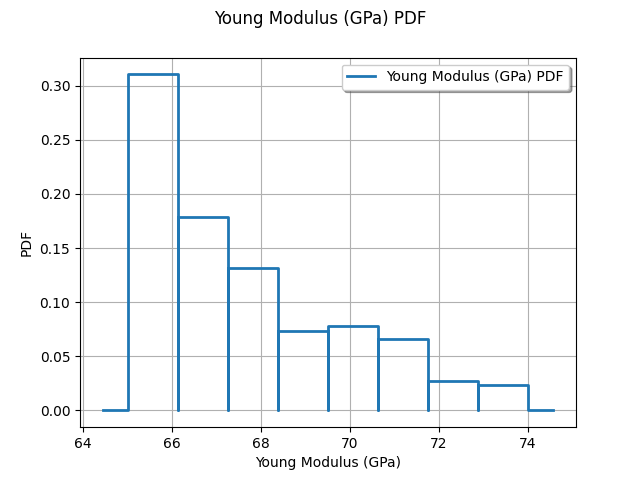

In [9]:
ot.HistogramFactory().build(data).drawPDF()

## Solution de la question 3 : ajuster une loi Beta

Estimons les paramètres de la loi `Beta` :

In [10]:
E = ot.BetaFactory().build(data)
print(E)

Beta(alpha = 0.690115, beta = 1.67629, a = 64.9639, b = 74.0455)


In [11]:
estimatedParameters = E.getParameter()
print("Paramètres estimés :")
print(estimatedParameters)
print("Paramètres exacts :")
print(exact_parameters)

Paramètres estimés :
[0.690115,1.67629,64.9639,74.0455]
Paramètres exacts :
[0.9,2.6,65,75]


On observe qu'il y a des petites différences entre le vecteur des paramètres estimés et le vecteur des paramètres exacts. Ces différences sont dues à la taille finie de l'échantillon. Lorsque la taille de l'échantillon tend vers l'infini, les estimateurs convergent vers la vraie valeur des paramètres.

La méthode `build()` retourne une instance de la classe `Distribution`. 

In [12]:
type(E)

openturns.model_copula.Distribution

Si on souhaite obtenir une instance de la classe `Beta`, on utilise la méthode `buildAsBeta()`. 

In [13]:
betaFactory = ot.BetaFactory()
E = betaFactory.buildAsBeta(data)
print(E)
print(type(E))

Beta(alpha = 0.690115, beta = 1.67629, a = 64.9639, b = 74.0455)
<class 'openturns.dist_bundle1.Beta'>


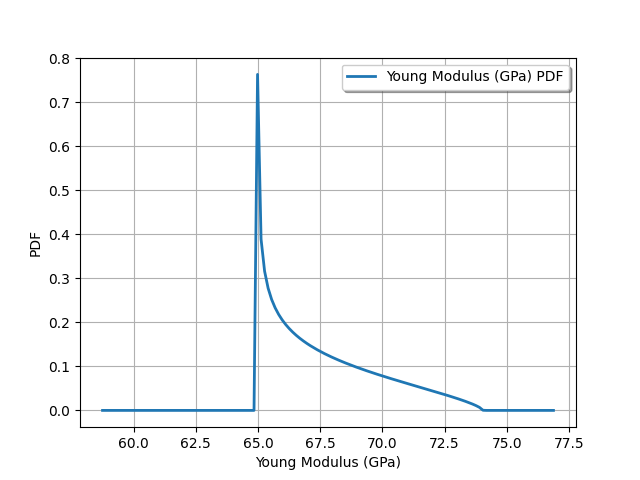

In [14]:
E.drawPDF()

In [15]:
E.getParametersCollection()[0]

class=PointWithDescription name=Young Modulus (GPa) dimension=4 description=[alpha,beta,a,b] values=[0.690115,1.67629,64.9639,74.0455]

Puisque les paramètres sont estimés à partir d'un échantillon, ils ont une distribution. Le script suivant calcule un intervalle de confiance à 95% pour chaque paramètre.

In [16]:
confidenceLevel = 0.95  # Le niveau de confiance pour chaque paramètre
description = data.getDescription()
betaFactory = ot.BetaFactory()
estimator = betaFactory.buildEstimator(data)
paramDist = estimator.getParameterDistribution()
parameterDimension = paramDist.getDimension()
parameterDescription = ["alpha", "beta", "a", "b"]
for i in range(parameterDimension):
    marginalDistribution = paramDist.getMarginal(i)
    confidenceInterval = marginalDistribution.computeBilateralConfidenceInterval(
        confidenceLevel
    )
    print(f"{parameterDescription[i]} (#{i+1}/{parameterDimension}) : {confidenceInterval}")


alpha (#1/4) : [0.553268, 0.829021]
beta (#2/4) : [1.23619, 2.20629]
a (#3/4) : [64.9618, 64.9766]
b (#4/4) : [73.2975, 74.2935]


## Solution de la question 4 : réaliser le test de Kolmogorov-Smirnov

Puisque les paramètres ont été estimés sur l'échantillon, il faut utiliser la classe `Lilliefors` fondée sur une `Factory`.

In [17]:
betafact = ot.BetaFactory()
fitted_dist, test_result = ot.FittingTest.Lilliefors(data, betafact)
fitted_dist

class=Beta name=Beta dimension=1 alpha=0.690115 beta=1.67629 a=64.9639 b=74.0455

In [18]:
test_result.getPValue()

0.2829724409448819

In [19]:
test_result.getThreshold()

0.05

In [20]:
test_result.getBinaryQualityMeasure()

True

La p-valeur est égale à 0.7615, ce qui implique que la distribution Beta ne peut pas être rejetée. Plus précisément, il n'y a pas assez de preuves pour rejeter l'hypothèse nulle $H_0$ au seuil de risque choisi.

## Solution de la question 5 : diagramme quantile-quantile

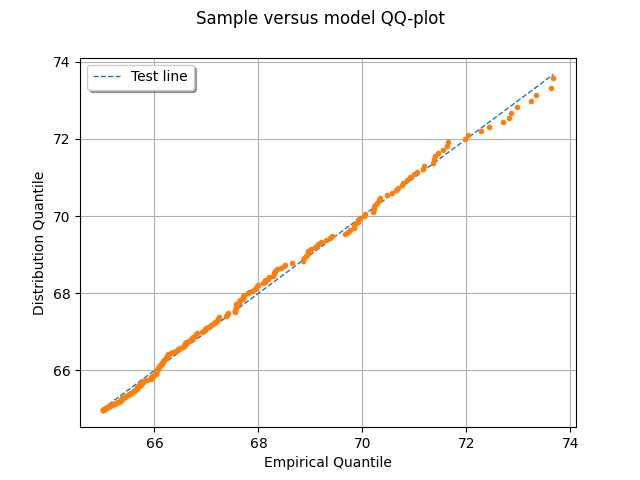

In [21]:
ot.VisualTest.DrawQQplot(data, E)

On constate que l'ajustement est satisfaisant, à l'exception peut-être des valeurs les plus grandes de $E$. 

## Solution de la question 6 : sélection de modèle par le critère BIC

In [22]:
bic = ot.FittingTest.BIC(data, E)
bic

3.9032449706026227

In [23]:
for factory in [
    ot.UniformFactory(),
    ot.NormalFactory(),
    ot.BetaFactory(),
]:
    distribution = factory.build(data)
    name = distribution.getName()
    numberOfEstimatedParameters = distribution.getParameterDimension()
    bic = ot.FittingTest.BIC(data, distribution, numberOfEstimatedParameters)
    print(f"{name} ({numberOfEstimatedParameters} paramètres) : BIC={bic}")

Uniform (2 paramètres) : BIC=4.459937122344618
Normal (2 paramètres) : BIC=4.502542440256779
Beta (4 paramètres) : BIC=3.9981571453371947


**Remarque.** Pour certaines distributions, la méthode d'estimation des coefficients peut échouer. Par exemple, l'estimation des paramètres de la loi `TruncatedNormal` échoue tant avec la méthode du maximum de vraisemblance qu'avec la méthode des moments. Voir le ticket [2814](https://github.com/openturns/openturns/issues/2814).

In [24]:
tested_factory_list = ot.DistributionFactory().GetContinuousUniVariateFactories()
len(tested_factory_list)

32

Une alternative consiste à utiliser la méthode statique `BestModelBIC`, qui retourne le meilleur modèle. 

In [25]:
dist, test_result = ot.FittingTest.BestModelBIC(data, tested_factory_list)
print(dist)
print(test_result)

WeibullMin(beta = 2.62127, alpha = 0.999791, gamma = 65.0029)
3.98945327296328


In [26]:
print(test_result)

3.98945327296328


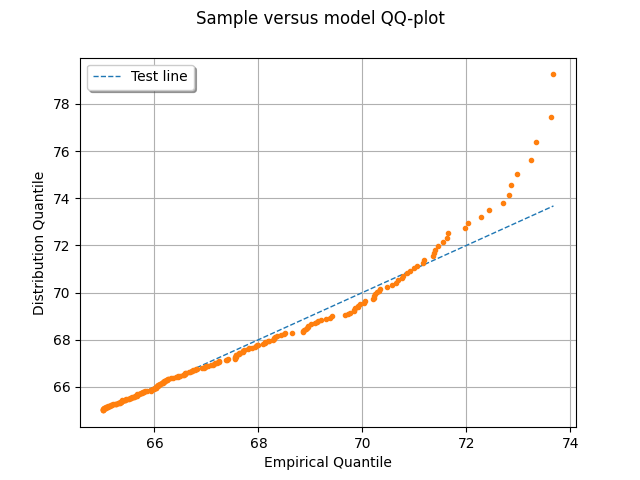

In [27]:
ot.VisualTest.DrawQQplot(data, dist)

On observe que la loi log-normale s'ajuste plutôt bien aux données, à l'exception peut-être des valeurs les plus grandes de $E$. 

## Solution de la question 7 : histogramme


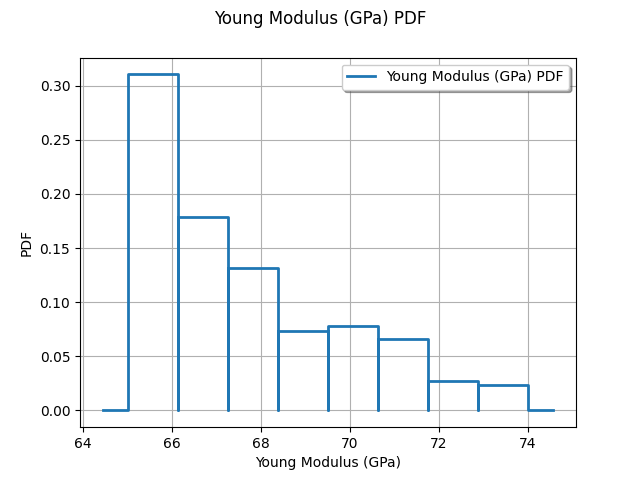

In [28]:
histogram = ot.HistogramFactory().build(data)
histogram.drawPDF()

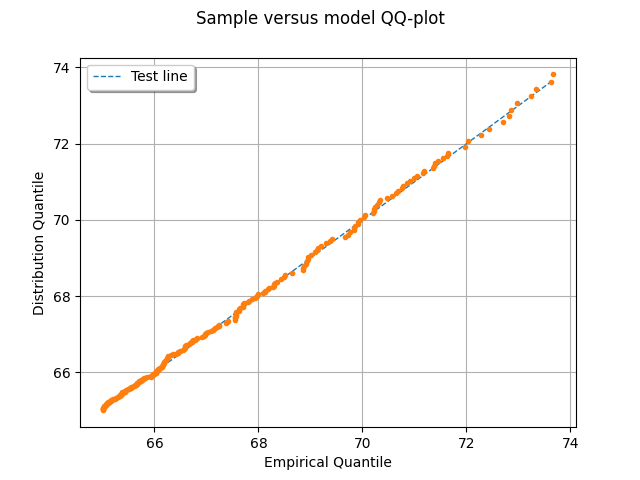

In [29]:
ot.VisualTest.DrawQQplot(data, histogram)

On observe que l'histogramme est plutôt satisfaisant, pour toutes les valeurs de l'échantillon. 

L'histogramme est une méthode intéressante, mais ne permet pas de générer des valeurs qui sont au-delà de l'échantillon. 

C'est une méthode qui peut être intéressante lorsqu'on dispose de beaucoup de données ou bien que l'étude est plutôt une étude de type tendance centrale. Si, au contraire, on possède peu de données ou bien que l'on s'intéresse aux extrêmes, alors l'histogramme ne peut pas convenir.

## Solution de la question 8 : méthode à noyau

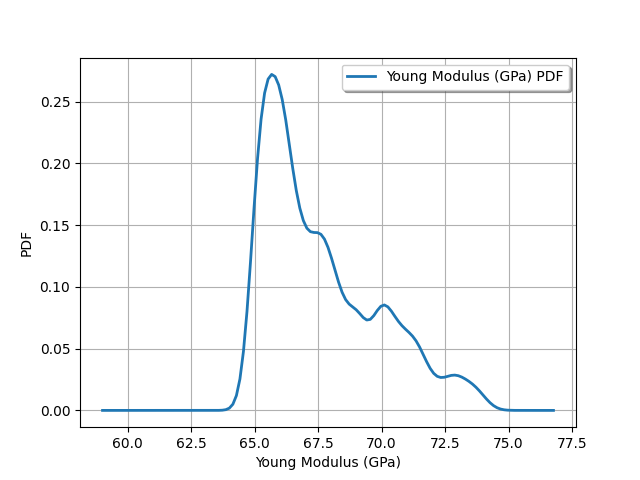

In [30]:
ks = ot.KernelSmoothing().build(data)
ks.drawPDF()

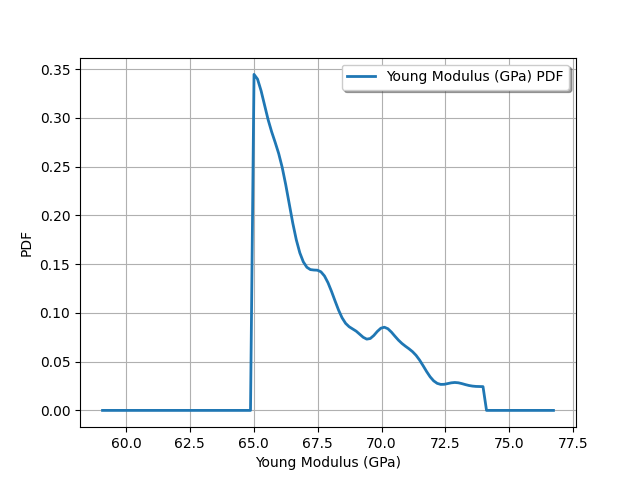

In [31]:
kde = ot.KernelSmoothing()
kde.setBoundaryCorrection(True)
ks = kde.build(data)
ks.drawPDF()

## Solution de la question 9 : synthèse

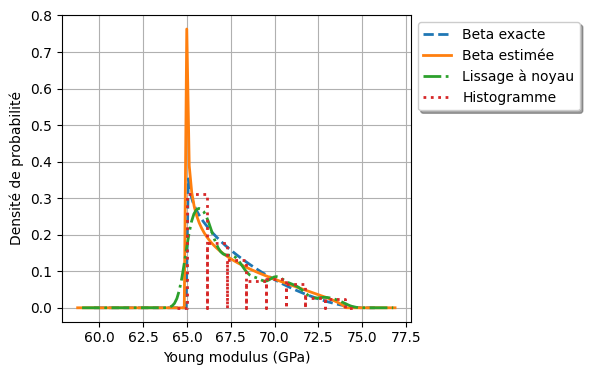

In [32]:
graph = ot.Graph("", "Young modulus (GPa)", "Densité de probabilité", True)
#
E_exact = ot.Beta()
E_exact.setParameter(exact_parameters)
graph_exact = E_exact.drawPDF()
graph_exact.setLegends(["Beta exacte"])
curve = graph_exact.getDrawable(0)
curve.setLineStyle("dashed")
graph.add(curve)
#
curve = ot.BetaFactory().build(data).drawPDF()
curve.setLegends(["Beta estimée"])
graph.add(curve)
#
curve = ot.KernelSmoothing().build(data).drawPDF()
curve.setLegends(["Lissage à noyau"])
curve = curve.getDrawable(0)
curve.setLineStyle("dotdash")
graph.add(curve)
#
curve = ot.HistogramFactory().build(data).drawPDF()
curve.setLegends(["Histogramme"])
curve = curve.getDrawable(0)
curve.setLineStyle("dotted")
graph.add(curve)
#
graph.setLegendCorner((1.0, 1.0))
graph.setLegendPosition("upper left")
_ = otv.View(graph, figure_kw={"figsize": (6.0, 4.0)})

On observe que la loi fondée sur l'estimation à noyau est moins régulière. On observe qu'elle est susceptible de générer des valeurs inférieures à $E = 65$ (GPa), alors qu'aucune donnée de ce type ne figure dans l'échantillon. On peut corriger ce défaut de l'estimateur par lissage en utilisant une méthode de _miroir_ (voir la méthode `setBoundaryCorrection()`). De toute évidence, c'est la loi Beta qui s'ajuste le mieux à ces données.